## QC


In [1]:
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import median_abs_deviation

sc.settings.verbosity = 0
sc.settings.set_figure_params(
    dpi=80,
    facecolor="white",
    frameon=False,
)

var_names (  str  , 默认:   'gene_symbols'  ) 用于标识基因名称的列名。
可以是：
- 'gene_symbols'  ：使用基因符号（通常是基因名）。
- 'gene_ids'  ：使用基因 ID（通常是 ENSEMBL ID）。
- 'index'  ：使用索引作为基因名称。

In [2]:
data1 = sc.read_10x_mtx(
    '/Users/secretloong/Shell/Shanxi_Medical_University/pbmc_1k_filtered_feature_bc_matrix',  
)
data1.obs['batch'] = '1k'
data1

AnnData object with n_obs × n_vars = 996 × 33538
    obs: 'batch'
    var: 'gene_ids', 'feature_types'

In [3]:
data2 = sc.read_10x_mtx(
    '/Users/secretloong/Shell/Shanxi_Medical_University/pbmc_3k_filtered_gene_bc_matrices', 
)
data2.obs['batch'] = '3k'
data2

AnnData object with n_obs × n_vars = 2691 × 35635
    obs: 'batch'
    var: 'gene_ids'

合并数据，并通过在每个重复基因名后附加数字字符串来使变量名唯一：'1'、'2'等

In [4]:
adata=sc.concat([data1,data2],join='outer')
adata.var_names_make_unique()

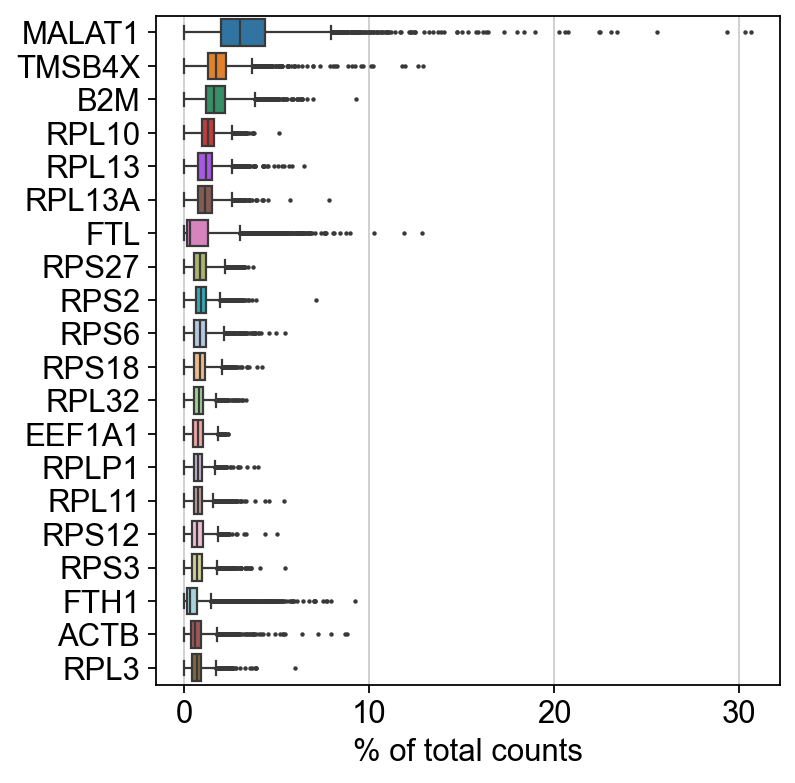

In [5]:
sc.pl.highest_expr_genes(adata, n_top=20)

In [6]:
# mitochondrial genes
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes.
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")
# QC metrics 
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True, percent_top=[20], log1p=True
)
adata

AnnData object with n_obs × n_vars = 3687 × 48678
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

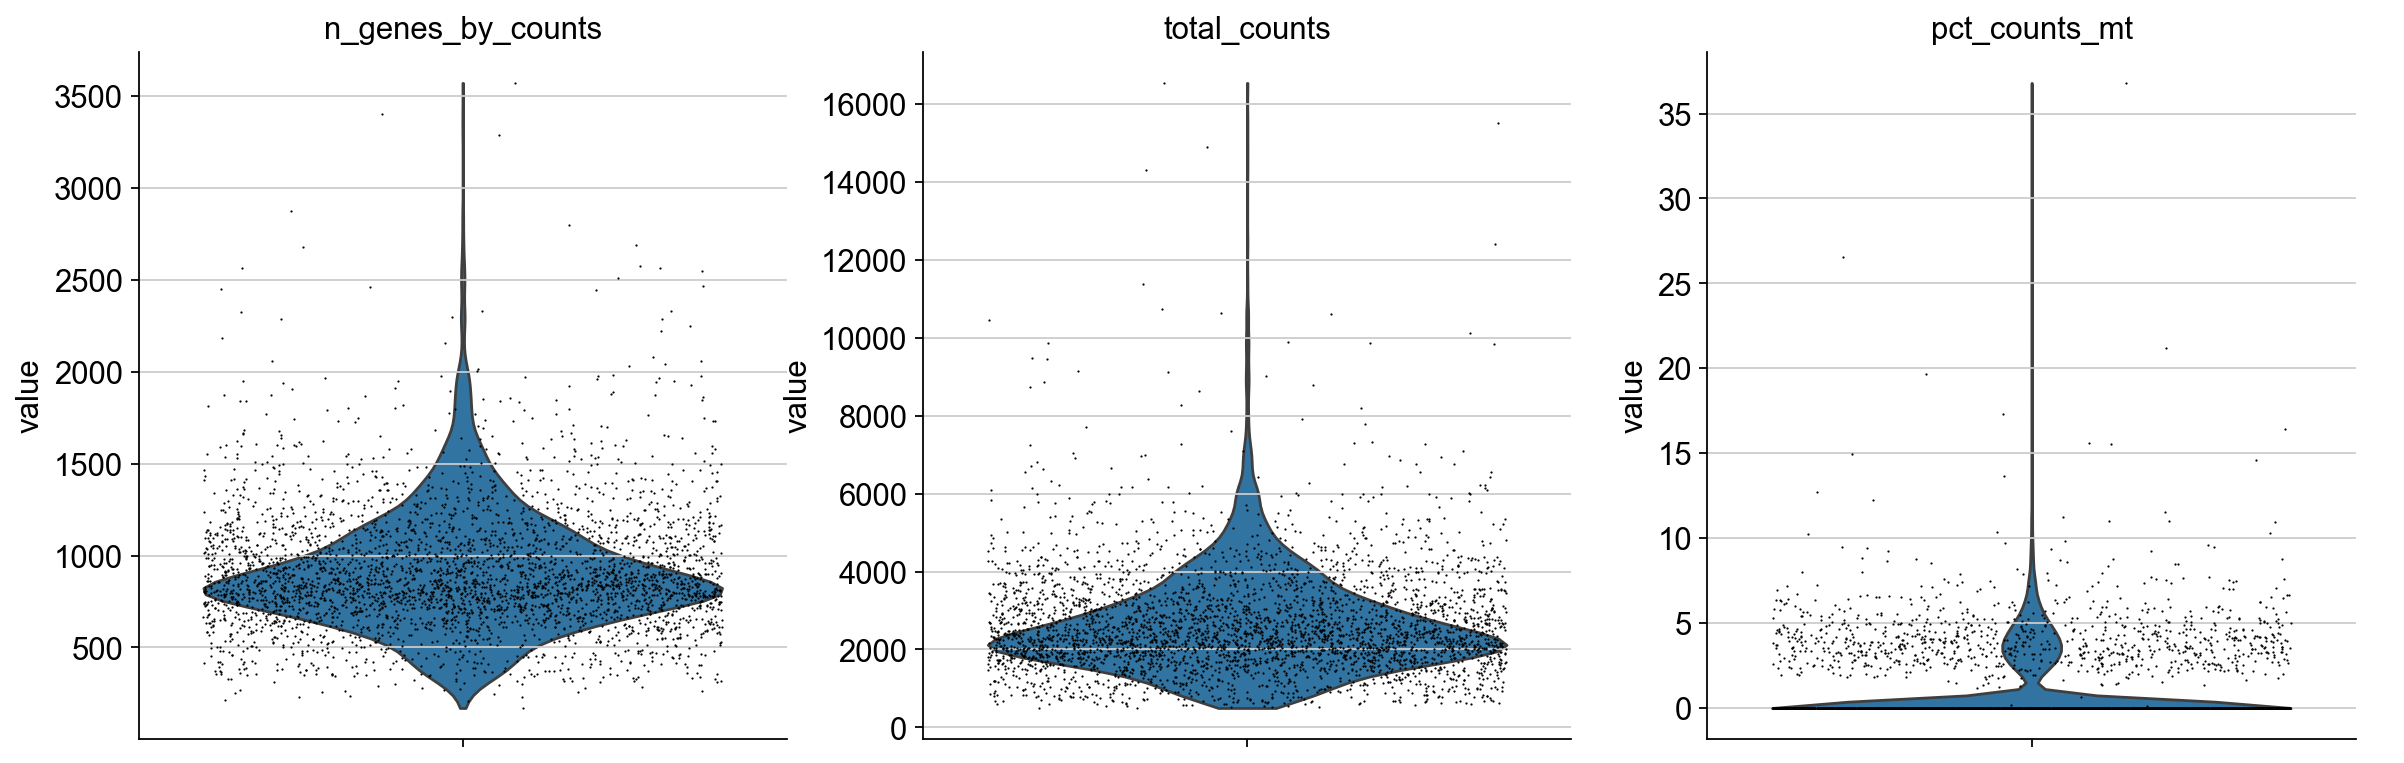

In [7]:
sc.pl.violin(adata, keys=["n_genes_by_counts",'total_counts','pct_counts_mt'], jitter=0.4, multi_panel=True)


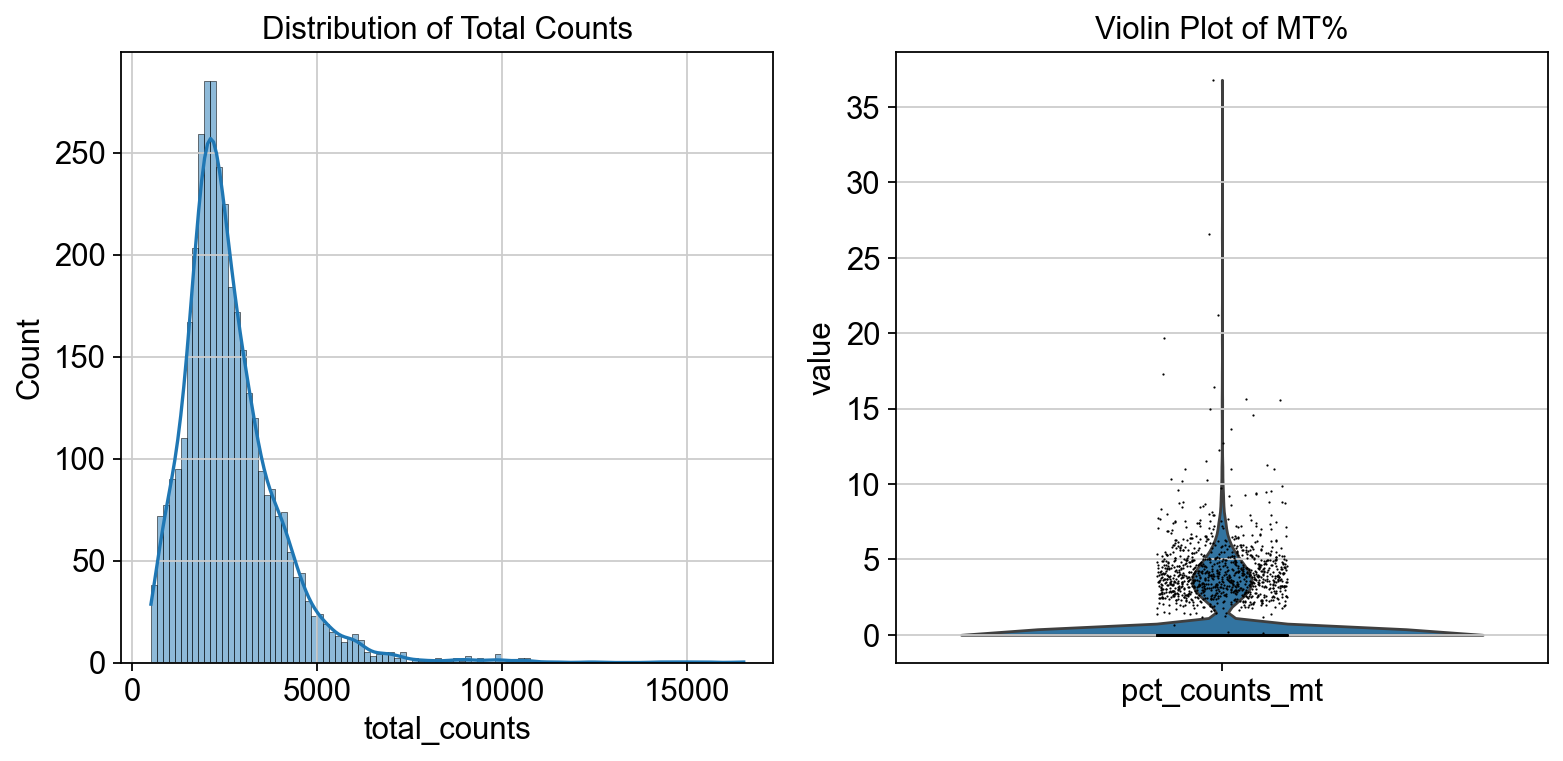

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot 1: Distribution plot
sns.histplot(data=adata.obs["total_counts"], bins=100, kde=True, ax=ax1)
ax1.set_title("Distribution of Total Counts")

# Plot 2: Violin plot
sc.pl.violin(adata, "pct_counts_mt", ax=ax2, show=False)
ax2.set_title("Violin Plot of MT%")

# Adjust layout to prevent legend overlap
plt.tight_layout()
plt.show()



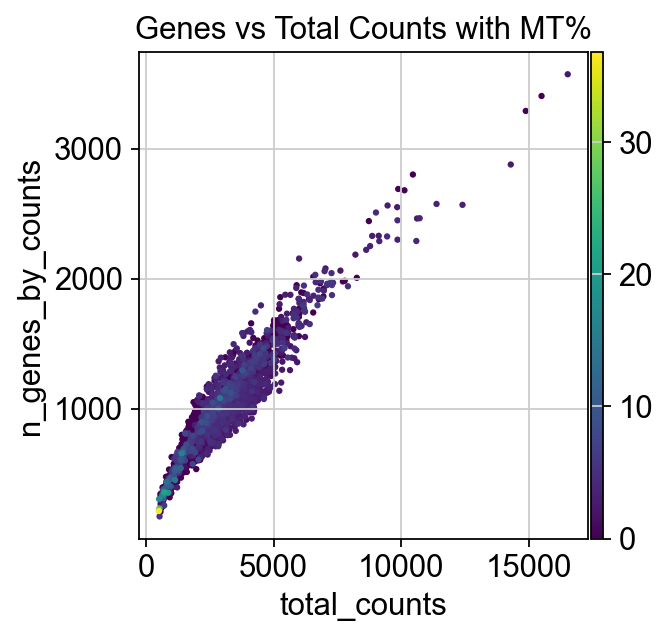

In [9]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt", 
            legend_loc='right margin', title="Genes vs Total Counts with MT%")


In [10]:
sc.pp.filter_cells(adata, min_genes=100)
# sc.pp.filter_genes(adata, min_cells=3)
adata = adata[adata.obs['pct_counts_mt']<10, :]

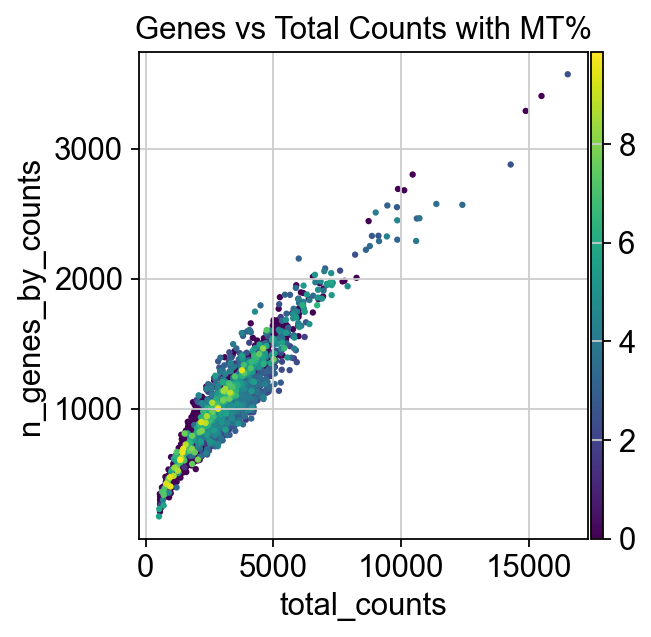

In [11]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt", 
            legend_loc='right margin', title="Genes vs Total Counts with MT%")


In [12]:
adata.obs.batch.value_counts()

batch
3k    2691
1k     975
Name: count, dtype: int64

## MAD (median absolute deviations/中位数绝对偏差)

In [ ]:
def is_outlier(adata, metric: str, nmads: int):
    M = adata.obs[metric]
    outlier = (M < np.median(M) - nmads * median_abs_deviation(M)) | (
        np.median(M) + nmads * median_abs_deviation(M) < M
    )
    return outlier

In [ ]:
adata.obs["outlier"] = (
    is_outlier(adata, "log1p_total_counts", 10)
    | is_outlier(adata, "log1p_n_genes_by_counts", 10)
    | is_outlier(adata, "pct_counts_in_top_20_genes", 10)
)
adata.obs.outlier.value_counts()

outlier
False    3678
True        9
Name: count, dtype: int64

In [ ]:
adata.obs["mt_outlier"] = is_outlier(adata, "pct_counts_mt", 10) | (
    adata.obs["pct_counts_mt"] > 10
)
adata.obs.mt_outlier.value_counts()

mt_outlier
False    2691
True      996
Name: count, dtype: int64

In [ ]:
print(f"Total number of cells: {adata.n_obs}")
adata = adata[(~adata.obs.outlier) & (~adata.obs.mt_outlier)].copy()

print(f"Number of cells after filtering of low quality cells: {adata.n_obs}")

Total number of cells: 3687
Number of cells after filtering of low quality cells: 2688


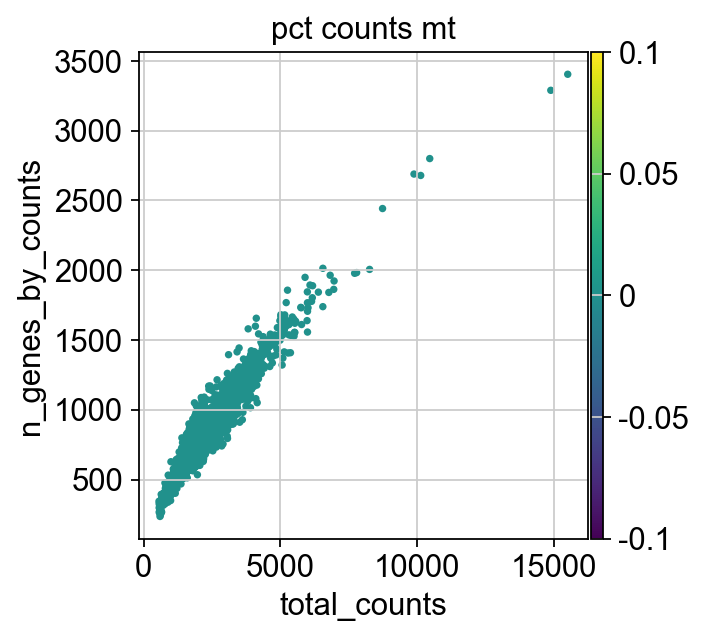

In [ ]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [ ]:
adata.obs.batch.value_counts()

batch
3k    2688
Name: count, dtype: int64

## soupX


In [13]:
import logging

import anndata2ri
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
# ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

Error importing in API mode: ImportError("dlopen(/Users/secretloong/.pyenv/versions/anaconda3-2024.10-1/envs/singlecell/lib/python3.10/site-packages/_rinterface_cffi_api.abi3.so, 0x0002): Library not loaded: /Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib\n  Referenced from: <21EE4B82-3593-3E9A-9C2F-834611EB708A> /Users/secretloong/.pyenv/versions/anaconda3-2024.10-1/envs/singlecell/lib/python3.10/site-packages/_rinterface_cffi_api.abi3.so\n  Reason: tried: '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file), '/Library/Frameworks/R.framework/Versions/4.5-arm64/Resources/lib/libRblas.dylib' (no such file)")
Trying to import in ABI mode.
/Users/secretloong/.pyenv/versions/anaconda3-2024.10-1/envs/singlecell/lib/python3.10/site-packages/rpy2/rinterface/__init__.py:1185: UserWarning

In [14]:
%%R
library(SoupX)


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

In [15]:
adata_pp = adata.copy()
sc.pp.normalize_per_cell(adata_pp)
sc.pp.log1p(adata_pp)
sc.pp.pca(adata_pp)
sc.pp.neighbors(adata_pp)
sc.tl.leiden(adata_pp, key_added="soupx_groups")

# Preprocess variables for SoupX
soupx_groups = adata_pp.obs["soupx_groups"]
del adata_pp

/var/folders/5m/xqp9ht6s4jj89_3g3hr8yfpm0000gn/T/ipykernel_97962/3790712543.py:2: FutureWarning: Use sc.pp.normalize_total instead
  sc.pp.normalize_per_cell(adata_pp)
/Users/secretloong/.pyenv/versions/anaconda3-2024.10-1/envs/singlecell/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:589: FutureWarning: Use sc.pp.normalize_total instead
  normalize_per_cell(
/Users/secretloong/.pyenv/versions/anaconda3-2024.10-1/envs/singlecell/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/var/folders/5m/xqp9ht6s4jj89_3g3hr8yfpm0000gn/T/ipykernel_97962/3790712543.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implem

In [16]:
cells = adata.obs_names
genes = adata.var_names
data = adata.X.T

In [17]:
adata_raw=sc.concat([data1,data2],join='outer')
adata_raw.var_names_make_unique()
data_tod = adata_raw.X.T
del adata_raw

In [18]:
data = data.toarray()
data_tod = data_tod.toarray()

In [19]:
%%R -i data -i data_tod -i genes -i cells -i soupx_groups -o out 

# specify row and column names of data
rownames(data) = genes
colnames(data) = cells
# ensure correct sparse format for table of counts and table of droplets
# data <- as(data, "sparseMatrix")
# data_tod <- as(data_tod, "sparseMatrix")

# Generate SoupChannel Object for SoupX 
sc = SoupChannel(data_tod, data, calcSoupProfile = FALSE)

# Add extra meta data to the SoupChannel object
soupProf = data.frame(row.names = genes, est = rowSums(data)/sum(data), counts = rowSums(data))
sc = setSoupProfile(sc, soupProf)
# Set cluster information in SoupChannel
sc = setClusters(sc, soupx_groups)

# Estimate contamination fraction
sc  = autoEstCont(sc, doPlot=FALSE)
# Infer corrected table of counts and rount to integer
out = adjustCounts(sc, roundToInt = TRUE)

out = as.matrix(out)

1861 genes passed tf-idf cut-off and 1297 soup quantile filter.  Taking the top 100.
Using 1318 independent estimates of rho.
Estimated global rho of 0.01
Expanding counts from 17 clusters to 3666 cells.
In addition: Warning messages:
1: In sparseMatrix(i = out@i[w] + 1, j = out@j[w] + 1, x = out@x[w],  :
  'giveCsparse' is deprecated; setting repr="T" for you
2: In asMethod(object) :
  sparse->dense coercion: allocating vector of size 1.3 GiB


In [20]:
adata.layers["counts"] = adata.X
adata.layers["soupX_counts"] = out.T
bdata=adata.copy()
bdata.X = bdata.layers["soupX_counts"]

/var/folders/5m/xqp9ht6s4jj89_3g3hr8yfpm0000gn/T/ipykernel_97962/1817819979.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X


In [21]:
print(f"Total number of genes: {adata.n_vars}")

# Min 20 cells - filters out 0 count genes
sc.pp.filter_genes(bdata, min_cells=3)
print(f"Number of genes after cell filter: {bdata.n_vars}")

Total number of genes: 48678
Number of genes after cell filter: 16123


In [22]:
adata

AnnData object with n_obs × n_vars = 3666 × 48678
    obs: 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    layers: 'counts', 'soupX_counts'

In [23]:
adata.obs.batch.value_counts()

batch
3k    2691
1k     975
Name: count, dtype: int64

## Doublet


In [24]:
%%R
library(Seurat)
library(scater)
library(scDblFinder)
library(BiocParallel)

Loading required package: SeuratObject
Loading required package: sp
‘SeuratObject’ was built with package ‘Matrix’ 1.7.2 but the current
version is 1.7.3; it is recomended that you reinstall ‘SeuratObject’ as
the ABI for ‘Matrix’ may have changed

Attaching package: ‘SeuratObject’

The following objects are masked from ‘package:base’:

    intersect, t

Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, 

In [25]:
data_mat = adata.X.T.toarray()

In [26]:
%%R -i data_mat -o doublet_score -o doublet_class

set.seed(123)
sce = scDblFinder(
    SingleCellExperiment(
        list(counts=data_mat),
    ) 
)
doublet_score = sce$scDblFinder.score
doublet_class = sce$scDblFinder.class

Creating ~2933 artificial doublets...
Dimensional reduction
Evaluating kNN...
Training model...
iter=0, 315 cells excluded from training.
iter=1, 288 cells excluded from training.
iter=2, 276 cells excluded from training.
Threshold found:0.382
103 (2.8%) doublets called


In [27]:
adata.obs["scDblFinder_score"] = doublet_score
adata.obs["scDblFinder_class"] = doublet_class
adata.obs.scDblFinder_class.value_counts()

scDblFinder_class
singlet    3563
doublet     103
Name: count, dtype: int64

In [28]:
adata.write("pbmc_quality_control.h5ad")

In [29]:
adata.obs.batch.value_counts()

batch
3k    2691
1k     975
Name: count, dtype: int64